In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# SIFT (Surface Invariant Feature Transform)
Previously discussed corner detectors (Harris and Shi-Tomasi) were rotation invariant. But when it comes to images of different scales, matching features becomes a common problem.

<center>Normal Detectors<img src="../resources/scaling.jpg"></center>

SIFT can work even after changing following parameters(other than scale. duh!):
- Rotation
- Illumination
- Viewpoint

### Breaking down and understanding the algorithm
#### 1. Constructing a scale space
You take the original image, and generate progressively blurred out images. Then, you resize the original image to half size. And you generate blurred out images again. And you keep repeating.
<img src="../resources/octave.jpg">
We generate several octaves of the original image. Each octave's image is half the size of previous one. In each octave, images are progressively blurred using the Gaussian Blur operator. Generally, 4 octaves and 5 blur levels are considered ideal for the algorithm.
#### 2. LoG (Laplacian of Gaussian) Approximations
From color space, we take images, blur them and calculate second order derivatives (Laplacian), which provides corners and edges. As second order derivatives are extremely sensitive to noise, it's necessary to apply blur in order to supress noise.

LOG is computationally heavy, so we opt for DoG (Difference of Gaussian), which produces approximately equivalent outputs as LoG, and is faster (less computations).

Two consecutive images in an octave are picked and subtracted. Then the next consecutive pair is taken, and the process repeats. This is done for all octaves. The resulting images are an approximation of scale invariant LoG (which is good for detecting keypoints).

$$L(x, y, \sigma) = G(x, y, \sigma) * I(x, y)$$

$$\sigma\text{ is the scale parameter. More is it's value, more is the blur}$$

$$\text{If amount of blur in an image of an octave is }\sigma\text{, then amount of blur for next image in the same octave will be }k\sigma\text{, where k is any constant}$$

$$\text{Across octaves, }\sigma\text{ varies, and withing octaves, constant 'k' varies}$$
<img src="../resources/blur_amount.jpg">
#### 3. Keypoints Localization in DoG images
<img src="../resources/sift_local_extrema.jpg">
Each pixel is compared to it's 8 neighbours and 3x3 corresponding windows in image above and below it. Suppose, X is the pixel being compared here. It's marked as a keypoint if it's greatest or least among the 26(8 + 3x3 + 3x3) neighbours. Now, the approximate maxima and minima are located. To find accurate positions, we apply sub pixel accuracy method.

Using the available pixel data, subpixel values are generated. This is done by the Taylor expansion of the image around the approximate key point. We just need to find extreme points of the equation:
$$D(X) = D + (\frac{\delta D}{\delta X})^{T}X + \frac{1}{2}X^T\frac{\delta^{2}D}{\delta X^2}X$$
$$\text{D(X) is scale-space function, X = }(x, y, \sigma)^T$$
#### 4. Refining Keypoints
Remember that DoG contains not only corners but also edges. So, now we'll reject the low contrast and edge region keypoints.

<u>Removing low contrast keypoints</u>: If magnitude of current pixel in DoG image is less than a threshold, it's rejected. After this, we use taylor expansion to get intensity value at sub-pixel locations. If this is less than the threshold, the keypoint is rejected.

<u>Removing edge region keypoints</u>: A 2x2 Hessian matrix is used to calculate principal curvature, which is then used to find eigen values for the shape operator. We know that for edges, one eigen value is greater than the other. This way, edge region keypoinds are discarded as well.
#### 5. Rotation Invariance
A neighbourhood is taken around a keypoint depending on the scale, and gradient magnitude and direction is calculated in that region.
$$m(x, y) = \sqrt{(L(x+1, y) - L(x-1, y))^2 + (L(x, y+1) - L(x, y-1))^2}$$
$$\theta(x, y) = \tan^{-1}\frac{L(x, y+1) - L(x, y-1)}{L(x+1, y) - L(x-1, y)}$$
A histogram is made in which, the 360 degrees of orientation are broken into 36 bins (each of 10 degrees). The keypoint is assigned the index of the bin with maximum peak in the histogram. Also, all the other peaks above 80% of the maximum peak are converted to a new keypoint.
#### 6. Keypoint Descriptor
A 16x16 neigbourhood around the keypoint is taken, and is divided into 16 4x4 sub-blocks. For each 4x4 block, gradient magnitudes and orientations are calculated. These orientations are put into an 8 bin histogram. A gaussian weighting function is used to alter the orientation magnitudes before feeding them into the histogram. So total of 128 (4*4*8) bin values are available for each keypoint, which are then normalized. These numbers form "feature vector" or "feature descriptor", and it's unique for every keypoint.
#### 7. Final Touch
As feature vetors depend on gradient orientations, rotating the image will change the vector as well. But we want it to be rotation invariant. So, keypoint's orientation is subtracted from each orienation to make it each gradient orientation realtive to the orientation of the keypoint. Thresholding will provide the illumination invariance.

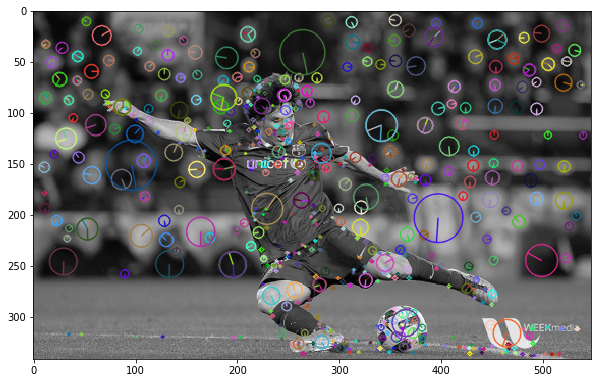

In [3]:
image = cv2.imread("../resources/messi.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

try:
    sift = cv2.SIFT()
except:
    sift = cv2.xfeatures2d.SIFT_create()

kp, descriptors = sift.detectAndCompute(gray, mask=None)
# print descriptors
# print len(kp), descriptors.shape

flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
# flags = cv2.DRAW_MATCHES_FLAGS_DEFAULT
try:
    image = cv2.drawKeypoints(gray, kp, flags=flags)
except:
    cv2.drawKeypoints(gray, kp, image, flags=flags)

fig = plt.figure()
fig.set_size_inches(10, 10)
fig.add_subplot(1,1,1)
plt.imshow(image)
plt.show()